<a href="https://colab.research.google.com/github/SrtaCamelo/nodule_detection/blob/main/nodule_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nodule Detection on LUNA images using UNET variations

In [1]:
!git clone https://github.com/SrtaCamelo/nodule_detection


Cloning into 'nodule_detection'...
remote: Enumerating objects: 1711, done.
remote: Counting objects: 100% (1711/1711), done.
remote: Compressing objects: 100% (1703/1703), done.
remote: Total 1711 (delta 10), reused 1698 (delta 5), pack-reused 0
Receiving objects: 100% (1711/1711), 4.89 MiB | 34.29 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [92]:
import cv2
import matplotlib.pyplot as plt
import keras_preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import os
import shutil

## Visualize Images from the Dataset

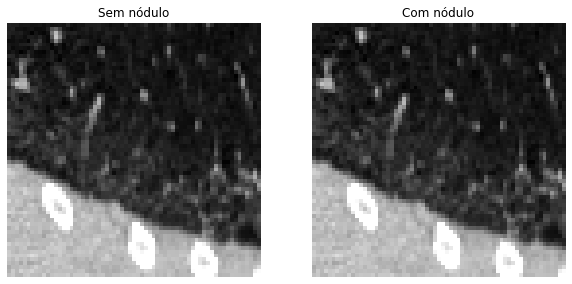

In [5]:
path_non = "nodule_detection/data/nan_nodule/diagx11.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.png" 
path_nod = "nodule_detection/data/nan_nodule/diagx11.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.png" 

img_nan = cv2.imread(path_non)
img_nodule = cv2.imread(path_nod)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()
ax[0].imshow(img_nan)
ax[0].set_title('Sem nódulo')
ax[0].set_axis_off()

ax[1].imshow(img_nodule)
ax[1].set_title('Com nódulo')
ax[1].set_axis_off()



In [6]:
main_path = "nodule_detection/data/"
files = ['nan_nodule','nodule']

### Run this once to remove ".ipynb_checkpoints" file from the data file.
This is necessary in order to avoid errors with the keras preprocessing step. Google Colab automaticaly generates checkpoint files in every folder, this extra file in the dataset folder confuses Keras dataset preprocessing function, making it assign 3 classes to the data instead of two (non-nodule and nodule).


In [7]:
achar = os.listdir(main_path)
print(achar)
if os.path.exists(main_path+".ipynb_checkpoints"):
  shutil.rmtree(main_path+".ipynb_checkpoints") 
achar = os.listdir(main_path)
print(achar)


['nan_nodule', 'nodule']
['nan_nodule', 'nodule']


## Arranging lung images in batches to Train Deep Learning models

In [77]:
 training_set = tf.keras.preprocessing.image_dataset_from_directory(main_path,subset="training",seed=1337, labels='inferred',validation_split=0.2,batch_size=batch_size, color_mode = "grayscale")
 validation_set = tf.keras.preprocessing.image_dataset_from_directory(main_path,subset="validation",seed=1337, labels='inferred',validation_split=0.2,batch_size=batch_size,color_mode = "grayscale")
 print(training_set)

Found 1800 files belonging to 2 classes.
Using 1440 files for training.
Found 1800 files belonging to 2 classes.
Using 360 files for validation.
<BatchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>


## Setting Batch size and image input size to transform dataset in Tensors

In [85]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 2

In [73]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  main_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  main_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1800 files belonging to 2 classes.
Using 1440 files for training.
Found 1800 files belonging to 2 classes.
Using 360 files for validation.


In [74]:
class_names = train_ds.class_names
print(class_names)

['nan_nodule', 'nodule']


## Visualize Images inside Batches

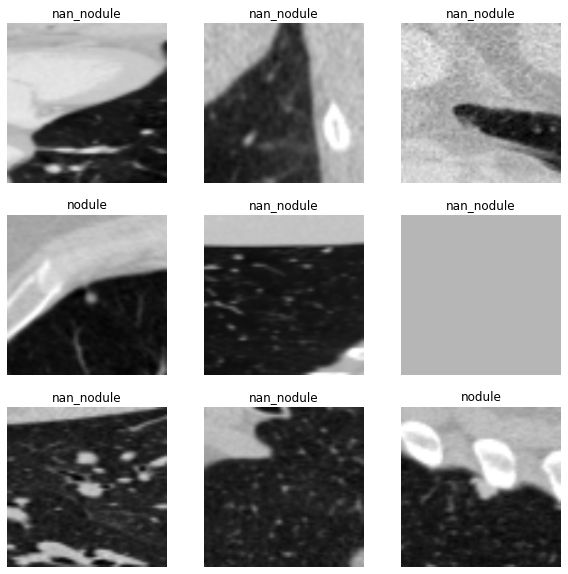

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Print Tensor shape and label shape (to code the Deep Learning Model accordingly)

In [76]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [79]:
for image_batch, labels_batch in training_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 1)
(32,)


In [78]:
 print(train_ds)

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


## Define Memory access / performance  for training

In [96]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [87]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [95]:
model.compile(optimizer = "adam", loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [90]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
45/45 [==============================] - 44s 913ms/step - loss: 7.5592 - accuracy: 0.5021 - val_loss: 7.5797 - val_accuracy: 0.4889
Epoch 2/10
45/45 [==============================] - 39s 877ms/step - loss: 7.5722 - accuracy: 0.5028 - val_loss: 7.6676 - val_accuracy: 0.4889
Epoch 3/10
45/45 [==============================] - 39s 879ms/step - loss: 7.6688 - accuracy: 0.5028 - val_loss: 7.6676 - val_accuracy: 0.4889
Epoch 4/10
45/45 [==============================] - 40s 883ms/step - loss: 7.6688 - accuracy: 0.5028 - val_loss: 7.6676 - val_accuracy: 0.4889
Epoch 5/10
45/45 [==============================] - 39s 875ms/step - loss: 7.6688 - accuracy: 0.5028 - val_loss: 7.6676 - val_accuracy: 0.4889
Epoch 6/10
45/45 [==============================] - 39s 874ms/step - loss: 7.6688 - accuracy: 0.5028 - val_loss: 7.6676 - val_accuracy: 0.4889
Epoch 7/10
45/45 [==============================] - 39s 876ms/step - loss: 7.6688 - accuracy: 0.5028 - val_loss: 7.6676 - val_accuracy: 0.4889

## Training Results

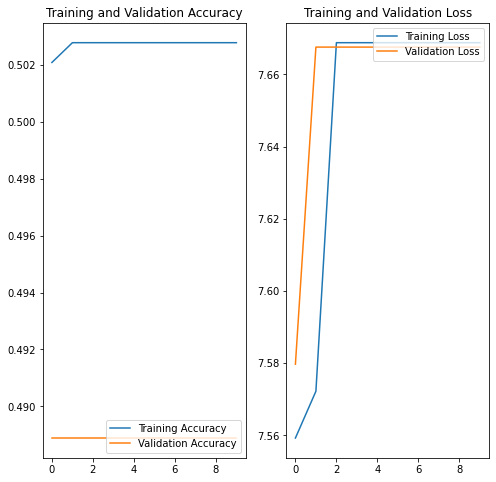

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## U-NET 

In [97]:
def unet(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer



In [98]:
input_layer = Input((img_size_target, img_size_target, 1))
unet_model = build_model(input_layer, 16)

NameError: ignored

## Attention U-NET